In [ ]:
#from pyspark.sql import SparkSession

# Initialize Spark session
#spark = SparkSession.builder.appName("SteamReviewsEDA").getOrCreate()

# Verify Spark session
spark

In [ ]:
from pyspark.sql.functions import min, max, mean, stddev, col, isnan, when, count, length, split, size

# Defining the relevant numeric columns
numeric_columns = [
    'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever',
    'author_playtime_last_two_weeks', 'author_playtime_at_review',
    'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count'
]

In [ ]:
# Path to CSV file in GCS
file_path = "gs://my-bigdata-project-bl/landing/all_reviews.csv"

# Loading the CSV file into a PySpark DataFrame
sdf = spark.read.csv(file_path, header=True, inferSchema=True)

# Showing the schema to verify the data types and structure
sdf.printSchema()

# Displaying the first few rows of the dataset
sdf.show(5)


root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: string (nullable = true)
 |-- author_playtime_forever: string (nullable = true)
 |-- author_playtime_last_two_weeks: string (nullable = true)
 |-- author_playtime_at_review: string (nullable = true)
 |-- author_last_played: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- writt

In [ ]:
# Counting the number of records (rows) in the dataset
record_count = sdf.count()
print(f"Total number of records: {record_count}")

Total number of records: 113885601


In [ ]:
# Counting missing (null or NaN) values in each column
missing_count = sdf.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in sdf.columns])

# Showing the count of missing values per column
missing_count.show()

+----------------+-----+----+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|appid|game|author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-----+----+--------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+

In [ ]:
# Filter out rows where any of the numeric columns are null or non-numeric
# We cast the columns to float (to handle both integers and floats) and filter out nulls or NaN values
for column in numeric_columns:
    sdf = sdf.filter(col(column).cast("float").isNotNull())

# Calculate min, max, mean, and standard deviation for each numeric column
# Using the `agg()` function with all aggregations in one go
agg_exprs = []
for column in numeric_columns:
    agg_exprs.append(min(col(column)).alias(f"{column}_min"))
    agg_exprs.append(max(col(column)).alias(f"{column}_max"))
    agg_exprs.append(mean(col(column)).alias(f"{column}_mean"))
    agg_exprs.append(stddev(col(column)).alias(f"{column}_stddev"))

# Aggregating and showing the results
result = sdf.agg(*agg_exprs)
result.show()

+--------------------------+--------------------------+---------------------------+-----------------------------+----------------------+----------------------+-----------------------+-------------------------+---------------------------+---------------------------+----------------------------+------------------------------+----------------------------------+----------------------------------+-----------------------------------+-------------------------------------+-----------------------------+-----------------------------+------------------------------+--------------------------------+------------+------------+-----------------+--------------------+---------------+---------------+------------------+-------------------+-----------------------+-----------------------+------------------------+--------------------------+-----------------+-----------------+------------------+--------------------+
|author_num_games_owned_min|author_num_games_owned_max|author_num_games_owned_mean|author_num_

In [ ]:
# Filtering for English reviews and non-null values in the review column
sdf = sdf.filter((col('language') == 'english') & (col('review').isNotNull()))

# Counting the total number of reviews (rows) after filtering
total_reviews = sdf.count()
print(f"Total number of English reviews: {total_reviews}")

# Adding a new column that counts the number of words in each review
# Split the review text on spaces and count the resulting array length
sdf = sdf.withColumn('word_count', size(split(col('review'), ' ')))
# Showing the review text and the word count (optional)
sdf.select('review', 'word_count').show(10)  # Show first 10 reviews and their word counts

# Calculating some stats about word counts
sdf.agg(
    min(col('word_count')).alias('min_words'),
    max(col('word_count')).alias('max_words'),
    mean(col('word_count')).alias('avg_words'),
    stddev(col('word_count')).alias('stddev_words')
).show()

Total number of English reviews: 50532471
+--------------------+----------+
|              review|word_count|
+--------------------+----------+
|        GOAT Game !!|         3|
|First crush. Alwa...|         6|
|best version of c...|         6|
|a game everyone n...|         8|
|        old but gold|         3|
|                   y|         1|
|cs2 update made t...|       206|
|     GAY NIGGER GAME|         3|
|Counter-Strike 1....|       191|
|               shoot|         1|
+--------------------+----------+
only showing top 10 rows



+---------+---------+-----------------+------------------+
|min_words|max_words|        avg_words|      stddev_words|
+---------+---------+-----------------+------------------+
|        1|   688500|35.95882746363225|170.72248461728992|
+---------+---------+-----------------+------------------+



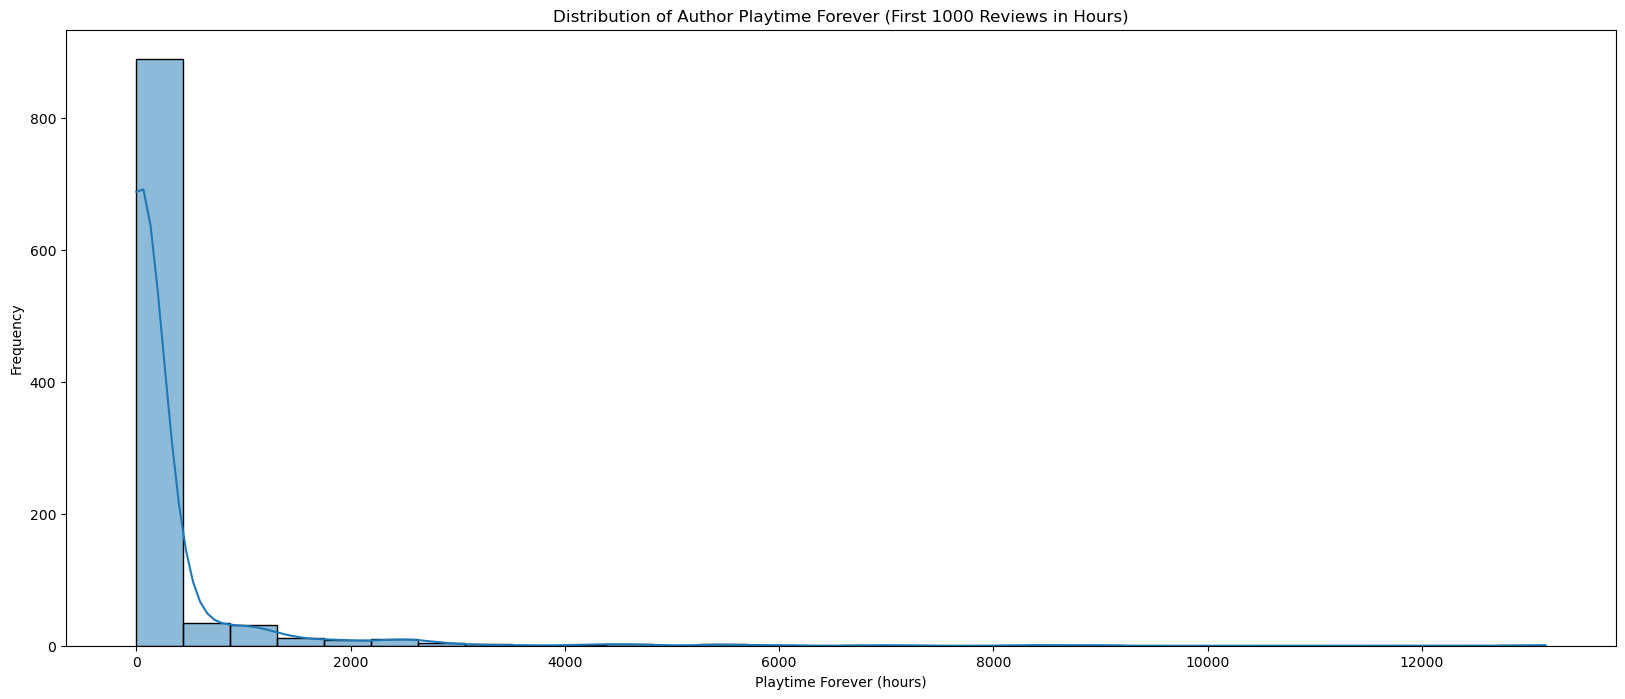

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select the first 1000 reviews and drop nulls
first_1000_reviews = sdf.select('author_playtime_forever').dropna().limit(1000)

# Convert to Pandas DataFrame
first_1000_reviews_pd = first_1000_reviews.toPandas()

# Converting any non-numeric values to numeric
first_1000_reviews_pd['author_playtime_forever'] = pd.to_numeric(
    first_1000_reviews_pd['author_playtime_forever'], errors='coerce'
)

# Handling any NULL values after conversion
first_1000_reviews_pd = first_1000_reviews_pd.dropna(subset=['author_playtime_forever'])

# Convert playtime from minutes to hours
first_1000_reviews_pd['author_playtime_forever'] = first_1000_reviews_pd['author_playtime_forever'] / 60

# Creating the histogram of the 'author_playtime_forever'
plt.figure(figsize=(20, 8))  # Set the figure size
sns.histplot(first_1000_reviews_pd['author_playtime_forever'], bins=30, kde=True)
plt.title('Distribution of Lifetime Playtime (First 1000 Reviews in Hours)')
plt.xlabel('Lifetime Playtime (hours)')
plt.ylabel('Frequency')
plt.show()


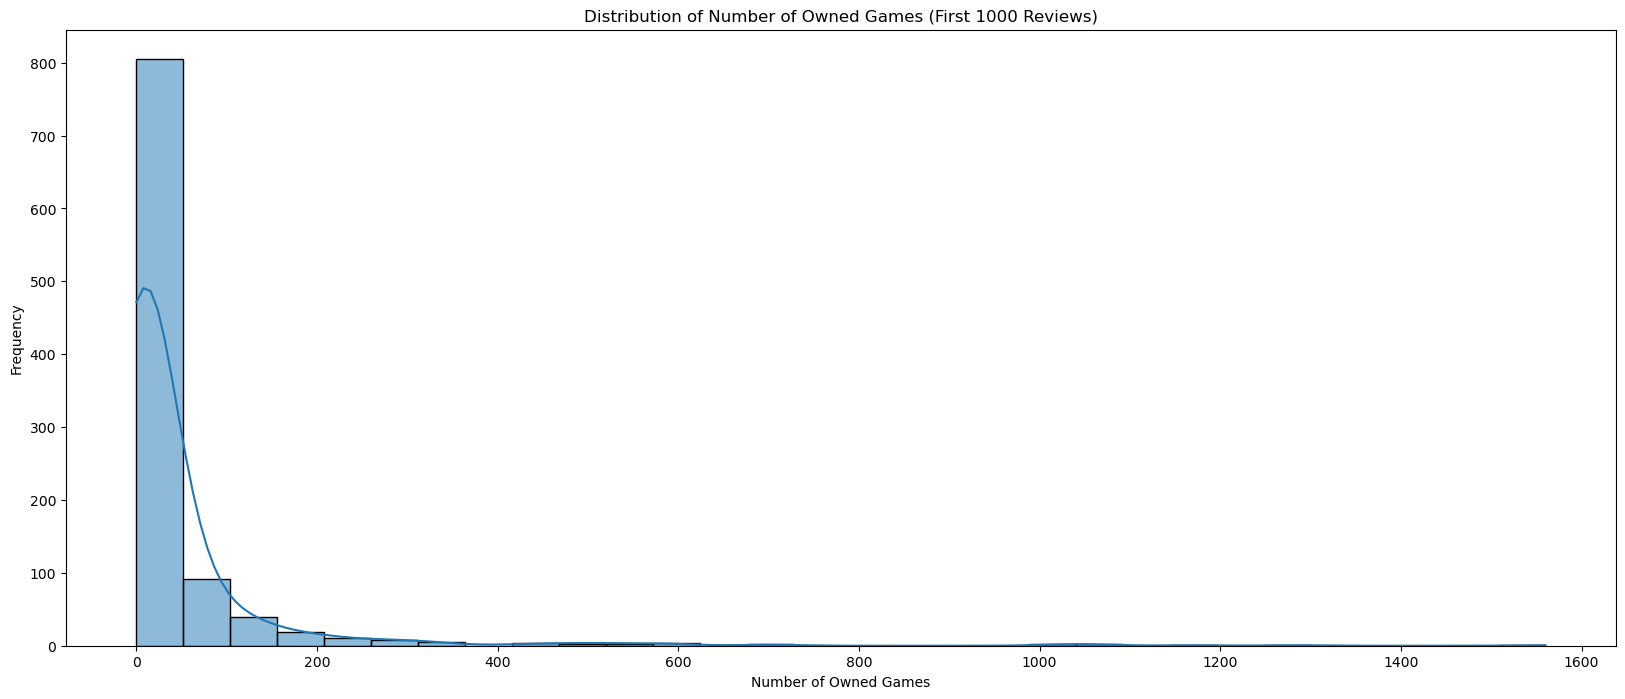

In [ ]:
# Selecting the first 1000 reviews for author_num_games_owned and dropping null values
first_1000_reviews = sdf.select('author_num_games_owned').dropna().limit(1000)

# Converting to Pandas DataFrame
first_1000_reviews_pd = first_1000_reviews.toPandas()

# Converting author_num_games_owned to numeric (handle non-numeric values)
first_1000_reviews_pd['author_num_games_owned'] = pd.to_numeric(
    first_1000_reviews_pd['author_num_games_owned'], errors='coerce'
)

# Drop NaN values after conversion
first_1000_reviews_pd = first_1000_reviews_pd.dropna(subset=['author_num_games_owned'])

# Showing the histogram
plt.figure(figsize=(20, 8))
sns.histplot(first_1000_reviews_pd['author_num_games_owned'], bins=30, kde=True)  # Plotting the histogram
plt.title('Distribution of Number of Owned Games (First 1000 Reviews)')
plt.xlabel('Number of Owned Games')
plt.ylabel('Frequency')
plt.show()

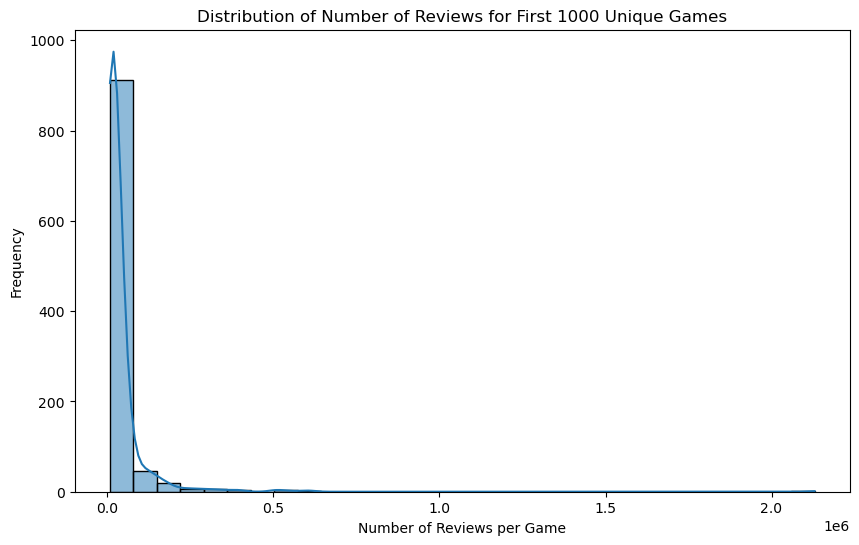

In [ ]:
# Selecting the first 1000 unique games based on appid and count their reviews
first_1000_unique_games = sdf.filter(sdf['language'] == 'english') \
                             .groupBy('appid') \
                             .count() \
                             .orderBy('count', ascending=False) \
                             .limit(1000)

# Converting to Pandas DataFrame
first_1000_unique_games_pd = first_1000_unique_games.toPandas()

# Showing histogram of the review count distribution for the first 1000 unique games
plt.figure(figsize=(10, 6))
sns.histplot(first_1000_unique_games_pd['count'], bins=30, kde=True)
plt.title('Distribution of Number of Reviews for First 1000 Unique Games')
plt.xlabel('Number of Reviews per Game')
plt.ylabel('Frequency')
plt.show()